<a href="https://colab.research.google.com/github/yodavo/IAI_vaccines/blob/main/data_wrangling/NLP_vaccines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **OBJETIVO DEL TRABAJO DE INVESTIGACION**

> Predecir si el paciente requiere hospitalizacion basado en los sintomas que presenta al inocularse la vacuna por clusters (no supervisado).

# **Paquetes**

In [1]:
# Instalar paquetes no disponibles
!pip install fuzzywuzzy

# Para importar la data
import os

# Importar para manipulacion de datos
import numpy as np
import pandas as pd
import datetime as dt
from statistics import *

# Importar para Visualizacion 
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
plt.style.use('seaborn-whitegrid')
import warnings # para evitar warnings
warnings.filterwarnings('ignore')
import textwrap
from textwrap import wrap
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

# Importar Dependencias
%matplotlib inline
%load_ext google.colab.data_table

# **Revision de variables**

In [2]:
 from google.colab import drive
drive.mount('/content/drive')

# Entrando a la carpeta de trabajo
%cd '/content/drive/MyDrive/Colab Notebooks/Diplomado-UTEC/Modulo5/dataset'

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/Diplomado-UTEC/Modulo5/dataset


In [3]:
# importar de VAERSData
data = pd.read_csv('pfizer_limpio.csv', index_col=0, encoding='latin-1')
print(f'VAER Pfizer-Hospitalized Data tiene\t: {data.shape[0]} observaciones y {data.shape[1]} variables.')

VAER Pfizer-Hospitalized Data tiene	: 10434 observaciones y 27 variables.


In [4]:
# Eliminando variables de corte y DATEDIED
data.drop(columns=['VAX_MANU', 'DATEDIED', 'HOSPITAL'], inplace=True)

In [5]:
# juntamos las cadenas de texto en una sola para extraer la informacion.
cadenas = ['HISTORY','SYMPTOM_TEXT', 'LAB_DATA', 'OTHER_MEDS', 'CUR_ILL', 'ALLERGIES', 'PRIOR_VAX']

# Creando columna INFO

In [6]:
# Cadenas de fillna
data.fillna({x:' ' for x in cadenas}, inplace=True)

# creamms una columan con toda la informacion textual
data['TEXT'] = data[cadenas].agg(" ".join, axis=1)

# eliminamos columnas que ya no aportan
data.drop(columns = cadenas, inplace=True)

In [7]:
# preprocesar texto
data.TEXT = data.TEXT.str.lower() # convertir en minuscula
data.TEXT = data.TEXT.str.replace('[^\w\s]',' ') # limpiar signos
data.TEXT = data.TEXT.str.rstrip() # limpiar espacios antes
data.TEXT = data.TEXT.str.lstrip() # limpiar especio despues

# Procesando INFO


In [8]:
# prueba para correr
dataset = data.copy()

In [9]:
aesis = {'infarct_myocardic' : ['myocardic','acute myocardial infarction', 'Myocardial infarction', 
                      'Silent myocardial infarction', 'acute myocardial injury',
                      'acute myocardial ischemia'], 
         'anaphylactic' : ['anaphylactic ', 'Anaphylactic reaction', 'Anaphylactic shock', 
                         'Anaphylactoid reaction', 'Anaphylactoid shock'], 
         'coagulopathy' : ['coagulopathy','Acquired amegakaryocytic thrombocytopenia', 
                         'Amegakaryocytic thrombocytopenia', 'Axillary vein thrombosis', 
                         'Cavernous sinus thrombosis', 'Cerebral venous thrombosis', 
                         'Deep vein thrombosis', 'Disseminated intravascular coagulation', 
                         'Embolism venous', 'Hepatic vein thrombosis',
                         'Immune thrombocytopenia', 'Intracranial venous sinus thrombosis',
                         'Mesenteric vein thrombosis', 'Portal vein thrombosis', 
                         'Pulmonary embolism', 'Pulmonary thrombosis', 'Pulmonary venous thrombosis', 
                         'Severe fever with thrombocytopenia syndrome', 'Subclavian vein thrombosis', 
                         'Thrombocytopenia', 'Thrombocytopenic purpura', 
                         'Thrombotic thrombocytopenic purpura', 'Thrombosis', 
                         'Transverse sinus thrombosis', 'Vena cava embolism', 
                         'Vena cava thrombosis', 'Venous thrombosis'], 
         'covid19' : ['COVID-19', 'Asymptomatic COVID-19', 'COVID-19 pneumonia'],
         'guillian' : ['guillian', 'Guillian-Barre syndrome'], 
         'miller' : ['miller', 'Miller Fisher syndrome'], 
         'polyneurapathy' : ['polyneurapathy','Demyelinating polyneuropathy'],
         'kawasaki' : ['kawasaki', 'Kawasakis disease'],
         'multisystem' : ['multisystem','Multisystem inflammatory syndrome in children',
                          'Multisystem Inflammatory Syndrome in Adults (MIS-A)'], 
         'myocarditis_pericarditis' : ['Atypical mycobacterium pericarditis', 
                          'Autoimmune myocarditis', 'Autoimmune pericarditis', 
                          'Bacterial pericarditis','Coxsackie myocarditis', 'Coxsackie pericarditis', 
                          'Cytomegalovirus myocarditis', 'Cytomegalovirus pericarditis', 
                          'Enterovirus myocarditis','Eosinophilic myocarditis', 
                          'Hypersensitivity myocarditis', 'Immune mediated myocarditis', 
                          'Myocarditis', 'Myocarditis bacterial', 'Myocarditis helminthic', 
                          'Myocarditis infectious', 'Myocarditis meningococcal', 
                          'Myocarditis mycotic', 'Myocarditis post infection',
                          'Myocarditis septic', 'Viral myocarditis','Pericarditis','Pericarditis adhesive', 'Pericarditis constrictive', 
                          'Pericarditis helminthic', 'Pericarditis infective', 
                          'Pericarditis mycoplasma', 'Pleuropericarditis', 
                          'Purulent pericarditis', 'Viral pericarditis'],
         'narcolepsia' : ['Narcolepsy', 'Cataplexy'],
         'pregnancy' : ['Abortion','Aborted pregnancy', 'Abortion complete',' Abortion early', 
                       'Abortion incomplete', 'Abortion late', 'Abortion missed', 
                       'Abortion spontaneous', 'Abortion spontaneous complete', 
                       'Abortion spontaneous incomplete', 'Abortion threatened', 
                       'Congenital anomaly', 'Drug exposure during pregnancy', 
                       'Exposure during pregnancy', 'Foetal death Maternal',
                       'exposure during pregnancy' ,'Stillbirth'],
         'epilepsy_consulsions' : ['  Atonic seizures', 'Atypical benign partial epilepsy',
                       'Autonomic seizure', 'Clonic convulsion', 'Complex partial seizures', 
                       'Convulsion in childhood', 'Convulsion', 'Convulsions local', 
                       'Epilepsy' 'Epileptic encephalopathy' 'Febrile convulsion', 
                       'Febrile infection-related epilepsy syndrome', 
                       'Generalised non-convulsive epilepsy', 'Generalised onset non-motor seizure', 
                       'Generalised tonic-clonic seizure', 'Grand mal convulsion', 
                       'Idiopathic generalised epilepsy', 'Myoclonic epilepsy', 
                       'Neonatal seizure', 'Partial seizures with secondary generalisation', 
                       'Partial seizures', 'Petit mal epilepsy', 'Seizure anoxic', 
                       'Seizure cluster', 'Seizure like phenomena', 'Seizure', 
                       'Simple partial seizures', 'Status epilepticus', 
                       'Temporal lobe epilepsy','Tonic clonic movements', 
                       'Tonic convulsion', 'Tonic posturing'],
         'stroke':  ['Basal ganglia stroke', 'Brain stem stroke', 'Cerebellar stroke', 'Cerebrovascular accident', 
                       'Embolic stroke','Haemorrhagic stroke', 'Haemorrhagic transformation stroke', 
                       'Ischaemic stroke', 'Lacunar stroke', 'Perinatal stroke', 
                       'Spinal stroke', 'Thrombotic stroke', 'Vertebrobasilar stroke'],
         'Transverse myelitis':['Transverse myelitis'],
         'adrs' : ['Acute Respiratory Distress Syndrome'],
         'autoimmuned' : ['Autoimmune disorders NEC', 'Blood autoimmune disorders', 
                          'Endocrine autoimmune disorders', 'Hepatic autoimmune disorders', 
                          'Lupus erythematosus and associated conditions', 
                          'Muscular autoimmune disorders', 'Nervous system autoimmune disorders', 
                          'Rheumatoid arthritis and associated conditions', 
                          'Scleroderma and associated disorders', 'Skin autoimmune disorders NEC'],
         'adem' : ['Acute disseminated encephalomyelitis'], 
         'multipleesclerosis' : ['Multiple sclerosis', 'Multiple sclerosis relapse', 
                          'Primary progressive multiple sclerosis', 'Progressive multiple sclerosis', 
                          'Progressive relapsing multiple sclerosis', 'Relapsing multiple sclerosis', 
                          'Relapsing-remitting multiple sclerosis', 
                          'Secondary progressive multiple sclerosis', 'Tumefactive multiple sclerosis'],
         'opticneuritis' : ['Optic neuritis', 'neuritis'],
         'CIDP' : ['Chronic inflammatory demyelinating polyneuropathy'],
         'encephalitis' : ['Encephalitis'],
         'myelitis': ['Myelitis'],
         'Encephalomyelitis' : ['Encephalomyelitis', 'Leukoencephalomyelitis', 'Noninfective encephalomyeliti'],
         'meningoencephalitis' : ['Meningoencephalitis viral'],
         'meningitis' : ['Meningitis', 'Meningitis aseptic', 'Meningitis viral'],
         'encephalopathy' : ['Encephalopathy', 'Leukoencephalopathy'],
         'ataxia' : ['Ataxia', 'Cerebellar ataxia', 'Cerebral ataxia'],
         'noanaphylactic' : ['Allergic reaction to excipient', 'Allergy to vaccine', 
                             'Allergic bronchitis', 'Allergic colitis', 'Allergic cough', 
                             'Allergic cystitis', 'Allergic gastroenteritis', 
                             'Allergic hepatitis', 'Allergic keratitis', 
                             'Allergic pharyngitis', 'Allergic reaction to excipient', 
                             'Allergic respiratory disease', 'Allergic respiratory symptom', 
                             'Allergic sinusitis', 'Conjunctivitis allergic',
                             'Dermatitis allergic', 'Encephalitis allergic', 
                             'Encephalopathy allergic', 'Laryngitis allergic', 
                             'Nephritis allergic', 'Pruritus allergic', 'Rhinitis allergic']
         }

In [10]:
# Funcion de cambio para usar el diccionario de eventos aesi con cada observacion del dataframe
def aesisDetect(row, aesi):
  from fuzzywuzzy import fuzz
  sinonimos = aesis[aesi]
  contador = 0
  for sinonimo in sinonimos:
    if fuzz.partial_ratio(row,sinonimo.lower()) > 85 :
      #print(f'{sinonimo.lower()} : en : {row}')
      contador += 1
  return contador

In [11]:
# Procesamiento de lenguaje natural
for aesi in aesis.keys():
  dataset[aesi] = dataset.TEXT.apply(lambda x: aesisDetect(x, aesi))

# Visualizando los valores
for aesi in aesis.keys():
  print(dataset[aesi].value_counts())

0    10203
1      201
4       14
3        7
2        7
5        2
Name: infarct_myocardic, dtype: int64
0    10411
3       12
2        8
1        3
Name: anaphylactic, dtype: int64
0    10167
1      215
2       42
3       10
Name: coagulopathy, dtype: int64
0    7078
1    3303
2      53
Name: covid19, dtype: int64
0    10384
2       26
1       24
Name: guillian, dtype: int64
0    10433
1        1
Name: miller, dtype: int64
0    10430
1        3
2        1
Name: polyneurapathy, dtype: int64
0    10430
2        4
Name: kawasaki, dtype: int64
0    10433
1        1
Name: multisystem, dtype: int64
0     10170
1       248
2        10
14        3
16        2
3         1
Name: myocarditis_pericarditis, dtype: int64
0    10432
2        1
1        1
Name: narcolepsia, dtype: int64
0    10428
1        5
3        1
Name: pregnancy, dtype: int64
0     10092
1       331
2         9
13        1
4         1
Name: epilepsy_consulsions, dtype: int64
0     10324
1       104
2         4
12        2
Name: 

In [12]:
# BACKUP
backup = dataset.copy()

In [13]:
# Reemplazando valores numericos a binario (tipo onehotencoding)
for i in list(aesis.keys()):
  dataset[i] = np.where(dataset[i] > 0, 1, dataset[i])

# Visualizando los valores
for aesi in aesis.keys():
  print(dataset[aesi].value_counts())

0    10203
1      231
Name: infarct_myocardic, dtype: int64
0    10411
1       23
Name: anaphylactic, dtype: int64
0    10167
1      267
Name: coagulopathy, dtype: int64
0    7078
1    3356
Name: covid19, dtype: int64
0    10384
1       50
Name: guillian, dtype: int64
0    10433
1        1
Name: miller, dtype: int64
0    10430
1        4
Name: polyneurapathy, dtype: int64
0    10430
1        4
Name: kawasaki, dtype: int64
0    10433
1        1
Name: multisystem, dtype: int64
0    10170
1      264
Name: myocarditis_pericarditis, dtype: int64
0    10432
1        2
Name: narcolepsia, dtype: int64
0    10428
1        6
Name: pregnancy, dtype: int64
0    10092
1      342
Name: epilepsy_consulsions, dtype: int64
0    10324
1      110
Name: stroke, dtype: int64
0    10418
1       16
Name: Transverse myelitis, dtype: int64
0    10433
1        1
Name: adrs, dtype: int64
0    10433
1        1
Name: autoimmuned, dtype: int64
0    10434
Name: adem, dtype: int64
0    10403
1       31
Name: multiple

In [14]:
# creamos una columna con toda la informacion textual
dataset['decision'] = dataset[list(aesis.keys())].agg(np.sum, axis=1)

# Visualizando los valores
dataset.decision.value_counts()

0    6156
1    3813
2     431
3      33
4       1
Name: decision, dtype: int64

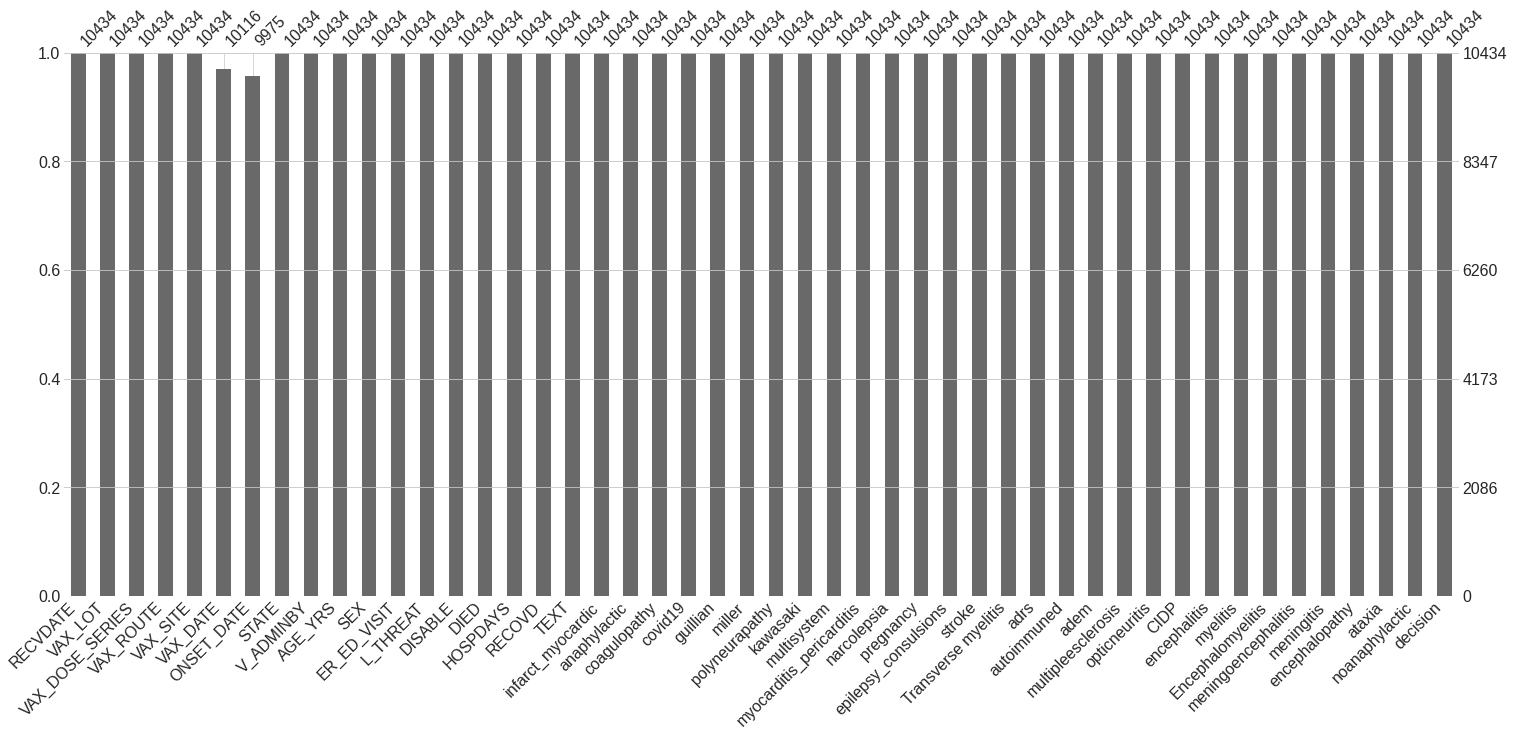

In [15]:
import missingno as msno
msno.bar(dataset)

In [16]:
## Ultima revision
print(f'Tenemos {dataset.loc[dataset["decision"] > 0].shape[0]} observaciones y {dataset.loc[dataset["decision"] > 0].shape[1]} variables para modelar.')

Tenemos 4278 observaciones y 48 variables para modelar.


In [17]:
# seleecionams las observaciones que tienen al menos un evento aesi
dataset = dataset.loc[dataset["decision"] > 0]

In [18]:
# eliminamos variables no utiles
dataset.drop(columns=['TEXT', 'decision'], inplace=True)

In [19]:
# eliminamos fechas
dataset = dataset.dropna()
dataset['RECVDATE'] =  dataset['RECVDATE'].apply(pd.to_datetime, format='%Y-%m-%d')
dataset['VAX_DATE'] =  dataset['VAX_DATE'].apply(pd.to_datetime, format='%Y-%m-%d')
dataset['ONSET_DATE'] =  dataset['ONSET_DATE'].apply(pd.to_datetime, format='%Y-%m-%d')

In [20]:
# renombrar columna y usar mayusculas para igualar valores.
dataset.columns = dataset.columns.str.lower()
dataset.vax_lot = dataset.vax_lot.str.upper()

In [21]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3782 entries, 917210 to 1497555
Data columns (total 46 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   recvdate                  3782 non-null   datetime64[ns]
 1   vax_lot                   3782 non-null   object        
 2   vax_dose_series           3782 non-null   int64         
 3   vax_route                 3782 non-null   object        
 4   vax_site                  3782 non-null   object        
 5   vax_date                  3782 non-null   datetime64[ns]
 6   onset_date                3782 non-null   datetime64[ns]
 7   state                     3782 non-null   object        
 8   v_adminby                 3782 non-null   object        
 9   age_yrs                   3782 non-null   int64         
 10  sex                       3782 non-null   object        
 11  er_ed_visit               3782 non-null   int64         
 12  l_threat    

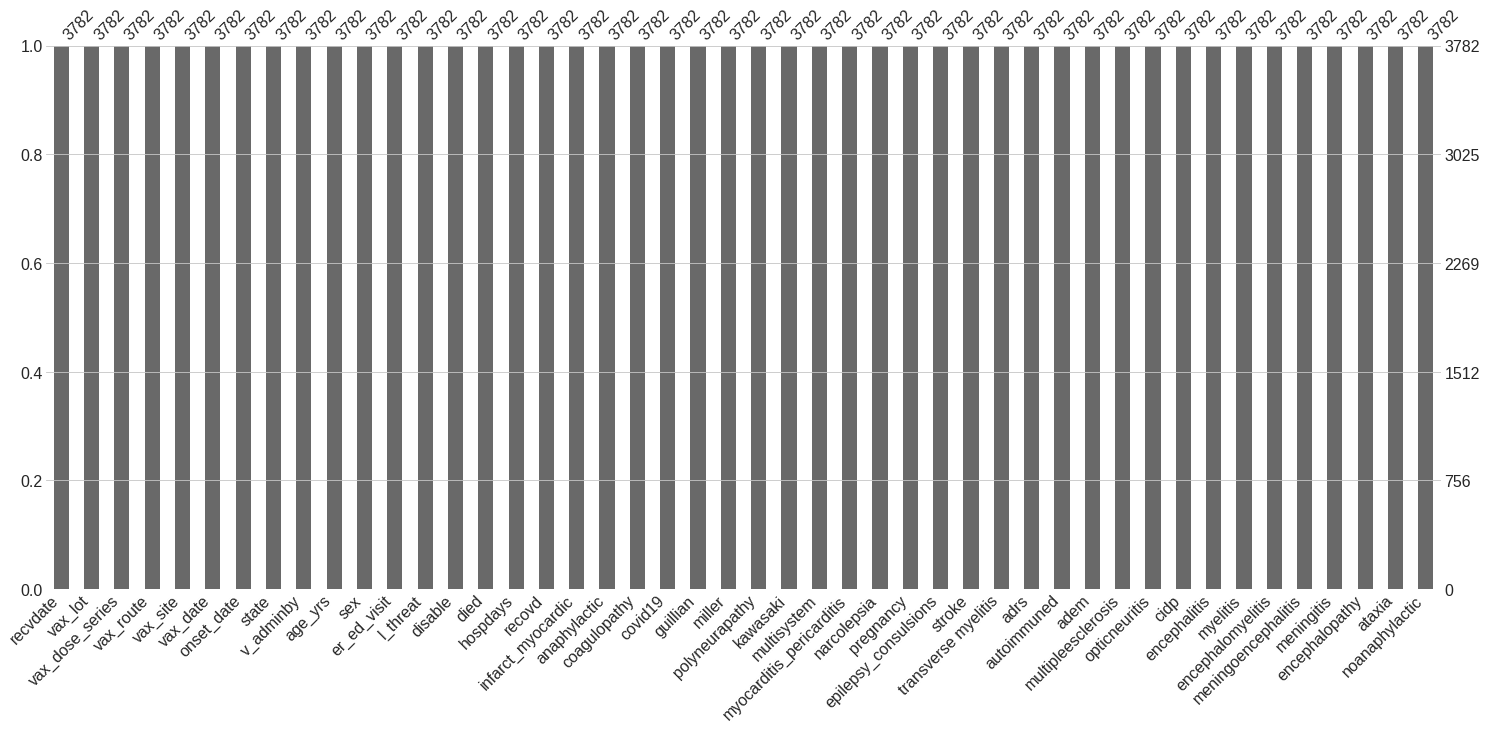

In [22]:
import missingno as msno
msno.bar(dataset)

In [23]:
# Exportando datasets
dataset.to_csv('/content/sample_data/dataset_aesi(final).csv')